In [1]:
import h2o
import pandas as pd
from h2o.estimators import H2OIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_231"; Java(TM) SE Runtime Environment (build 1.8.0_231-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.231-b11, mixed mode)
  Starting server from /Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpec49tgls
  JVM stdout: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpec49tgls/h2o_nmashayekhi_started_from_python.out
  JVM stderr: /var/folders/pf/w6ctt7r5639fbfclslj7nw2c0000gp/T/tmpec49tgls/h2o_nmashayekhi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_nmashayekhi_wzsvyf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"accepting new members, healthy"


In [2]:
train = h2o.import_file('train.csv')
test = h2o.import_file('test.csv')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [3]:
train.shape

(298, 12)

In [4]:
#Create new categorical column
nrows = len(train) #
l = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ncats = len(l)
newcol = l*(nrows//ncats) + l[:nrows%ncats]
train['CatCol'] = h2o.H2OFrame(newcol)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
#train = train.drop(['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'])

In [6]:
# Build an Isolation forest model
model = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [7]:
#model.params

In [8]:
#model.parms

# Calculate score
score = model.predict(test)
result_pred = score["predict"]

# Predict the leaf node assignment
ln_pred = model.predict_leaf_node_assignment(test, "Path")

result = test.cbind(score)

result[result["predict"] > 1]

In [9]:
score_train = model.predict(train)

isolationforest prediction progress: |████████████████████████████████████| 100%


# Visualize some of the trees

In [10]:
from h2o.tree import H2OTree
import subprocess
from IPython.display import Image

In [11]:
h2o.__file__

'/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/__init__.py'

In [12]:
downloads_path = "/Users/nmashayekhi/Downloads"
mojo_file_name = downloads_path + "/my_gbm_mojo.zip"
h2o_jar_path= "/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/" + "backend/bin/h2o.jar"
mojo_full_path = mojo_file_name
gv_file_path = downloads_path + "/my_gbm_graph.gv"

image_file_name = downloads_path + "/my_gbm_tree"

In [13]:
model.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

In [14]:
#function to generate a GraphViz tree from the saved MOJO model
def generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_path, tree_id = 0):
    image_file_path = image_file_path + "_" + str(tree_id) + ".png"
    result = subprocess.call(["java", "-cp", h2o_jar_path, "hex.genmodel.tools.PrintMojo", "--tree", 
                              str(tree_id), "-i", mojo_full_path , "-o", gv_file_path ], shell=False)
    result = subprocess.call(["ls",gv_file_path], shell = False)
    if result is 0:
        print("Success: Graphviz file " + gv_file_path + " is generated.")
    else: 
        print("Error: Graphviz file " + gv_file_path + " could not be generated.")

In [15]:
#function to generate the tree image as PNG from the saved GraphViz tree
def generateTreeImage(gv_file_path, image_file_path, tree_id):
    image_file_path = image_file_path + "_" + str(tree_id) + ".png"
    result = subprocess.call(["dot", "-Tpng", gv_file_path, "-o", image_file_path], shell=False)
    result = subprocess.call(["ls",image_file_path], shell = False)
    if result is 0:
        print("Success: Image File " + image_file_path + " is generated.")
        print("Now you can execute the follow line as-it-is to see the tree graph:") 
        print("Image(filename='" + image_file_path + "\')")
    else:
        print("Error: Image file " + image_file_path + " could not be generated.")

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


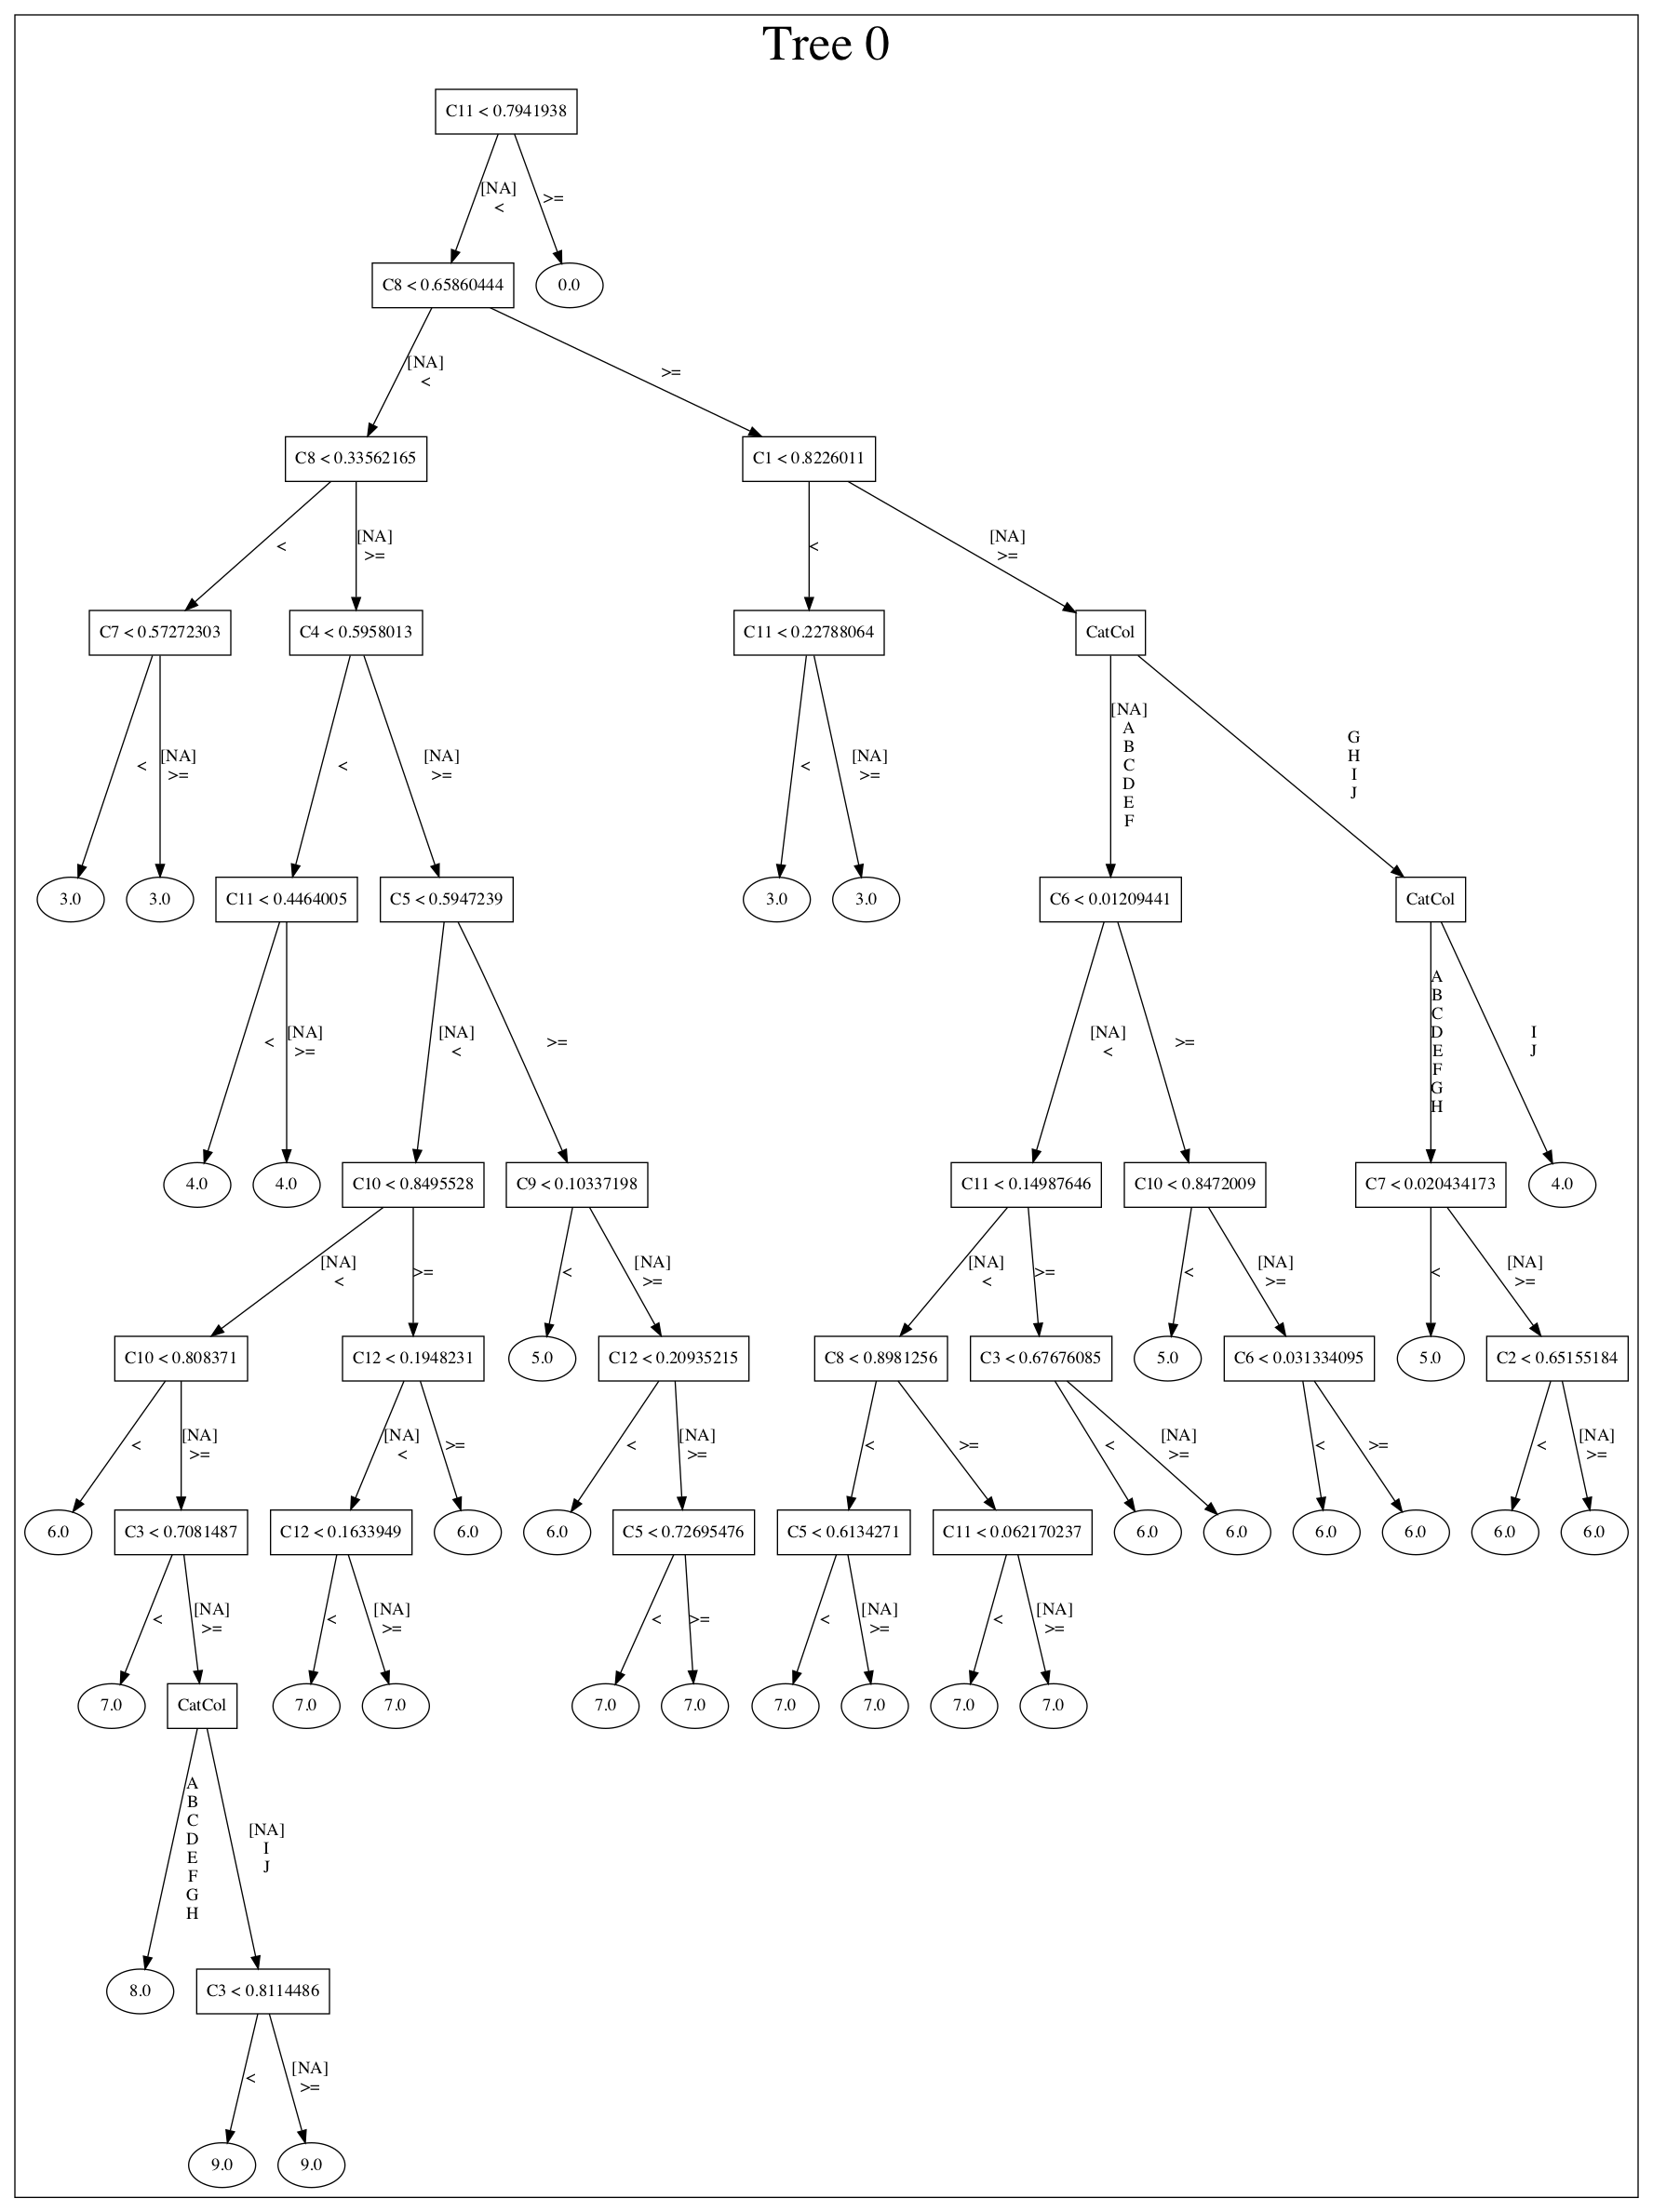

In [16]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_1.png')


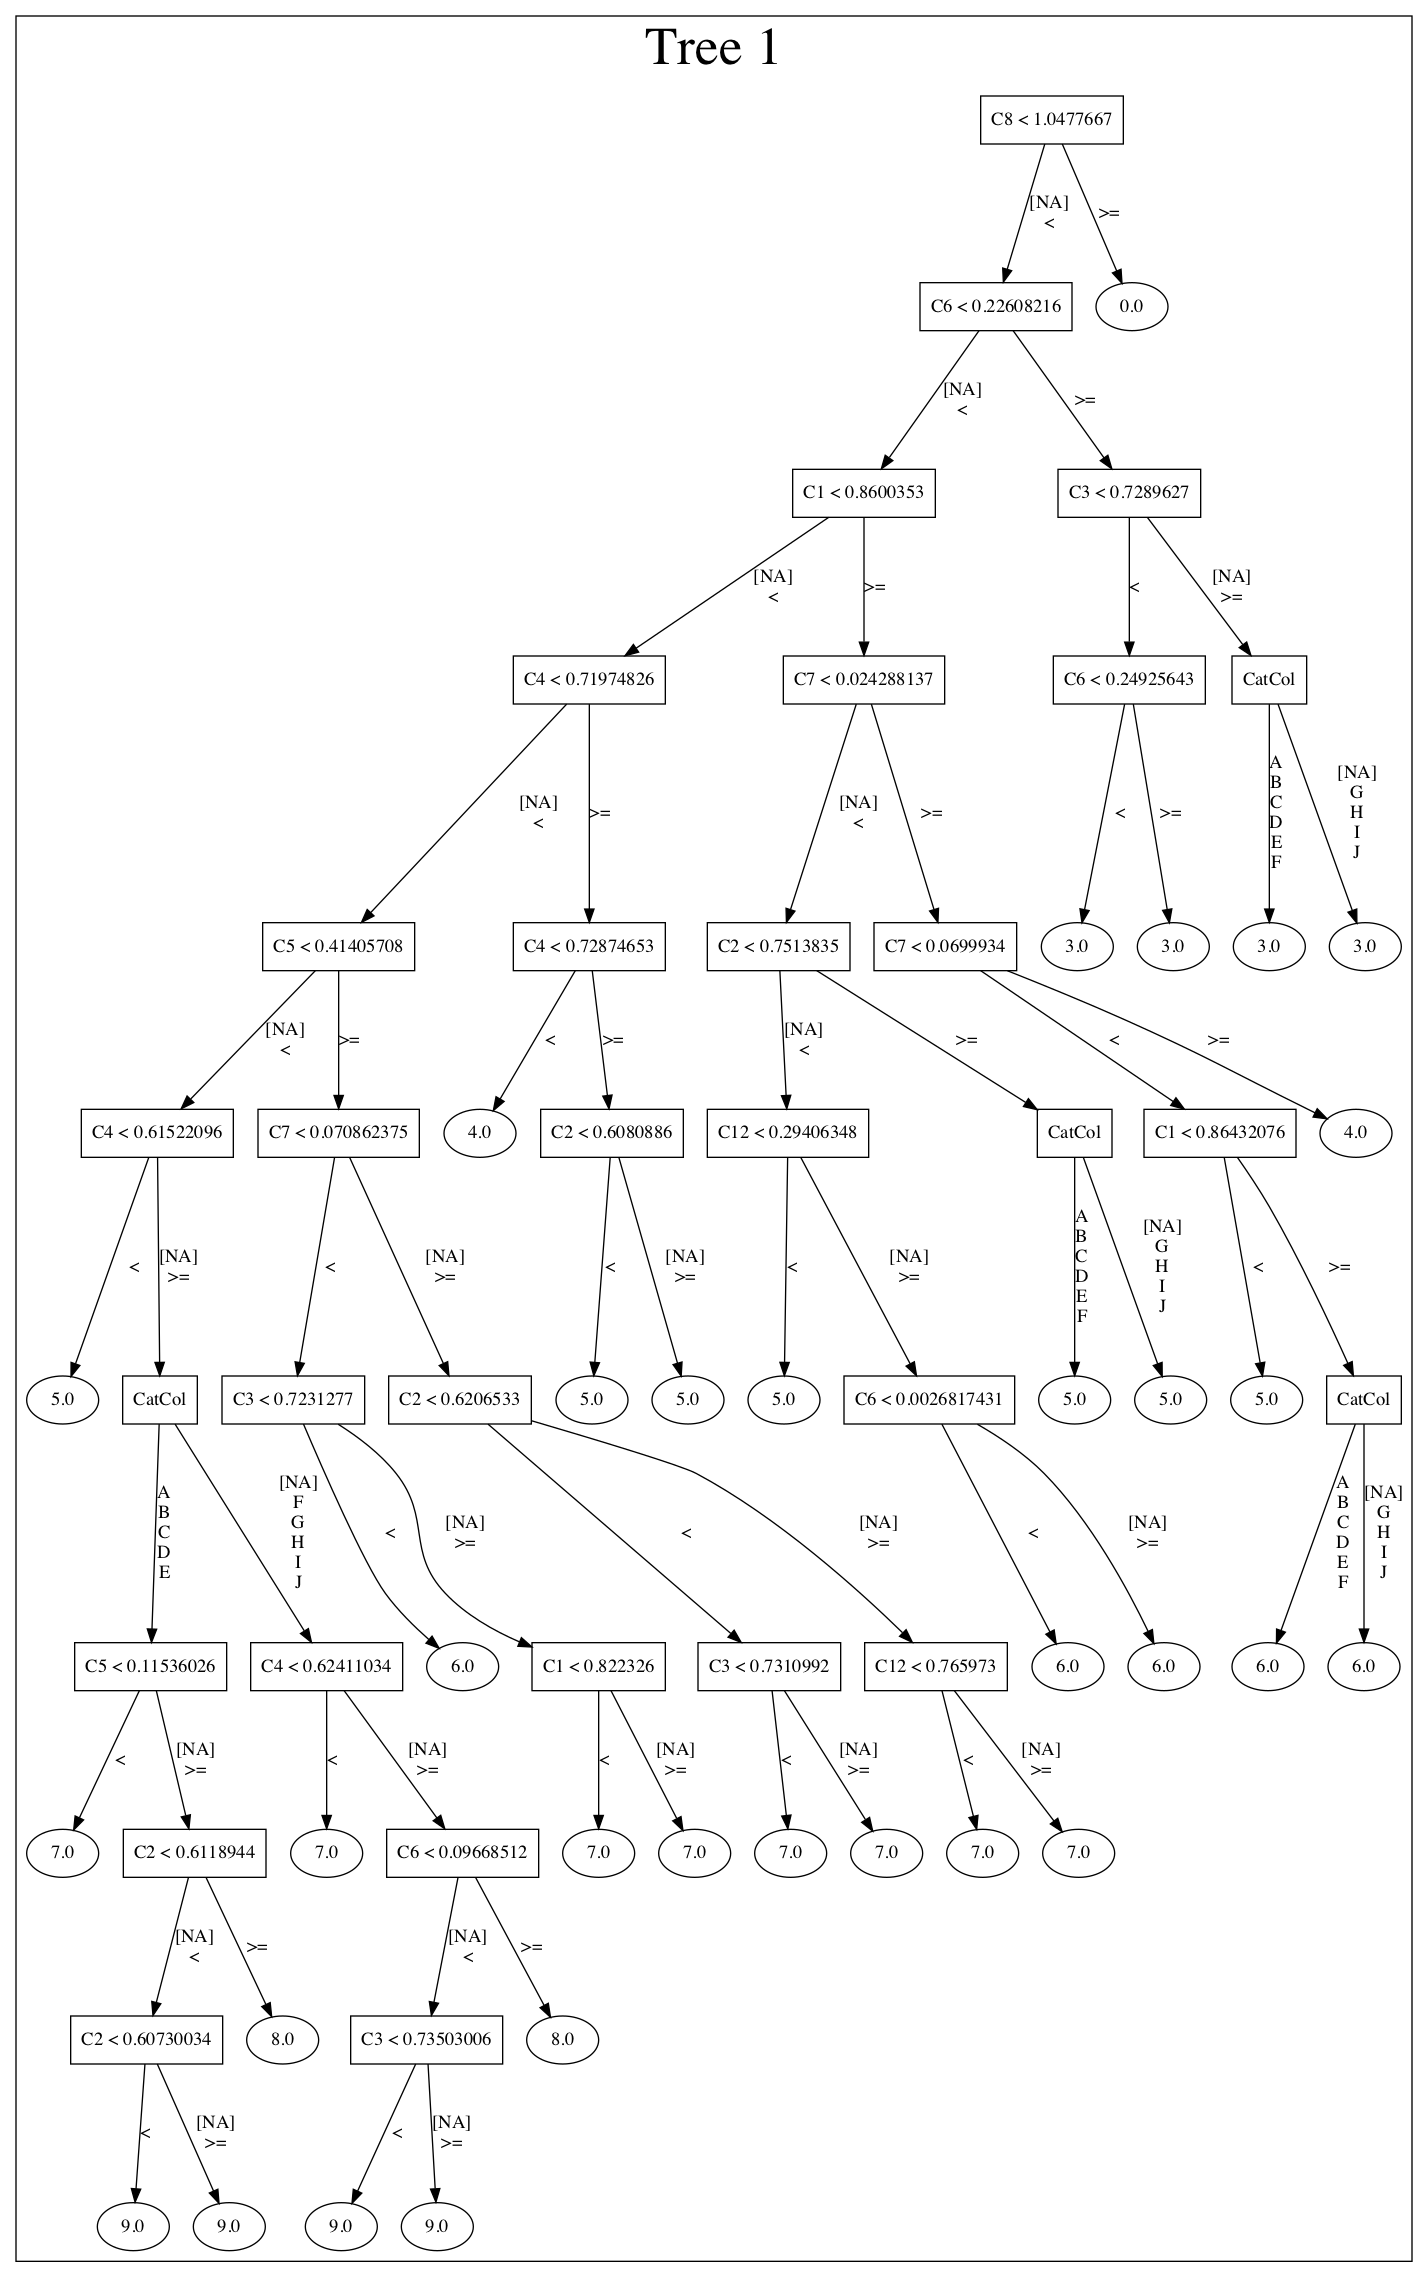

In [17]:
tree_num = 1
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

### ^The categories remain in order [A, B, C, D, ...]

## Model 2 - Add another 'Unordered' Column

In [18]:
#Create new categorical column
nrows = len(train) #
l = ['A', '7', 'B', '6', 'C', '5', 'D', '4', 'E', '3', 'F', '2', 'G', '1', 'H', '0', 'I', '-1', 'J']
ncats = len(l)
newcol = l*(nrows//ncats) + l[:nrows%ncats]
train['CatCol_with_Num'] = h2o.H2OFrame(newcol)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
# Build an Isolation forest model
model2 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model2.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [20]:
model2.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


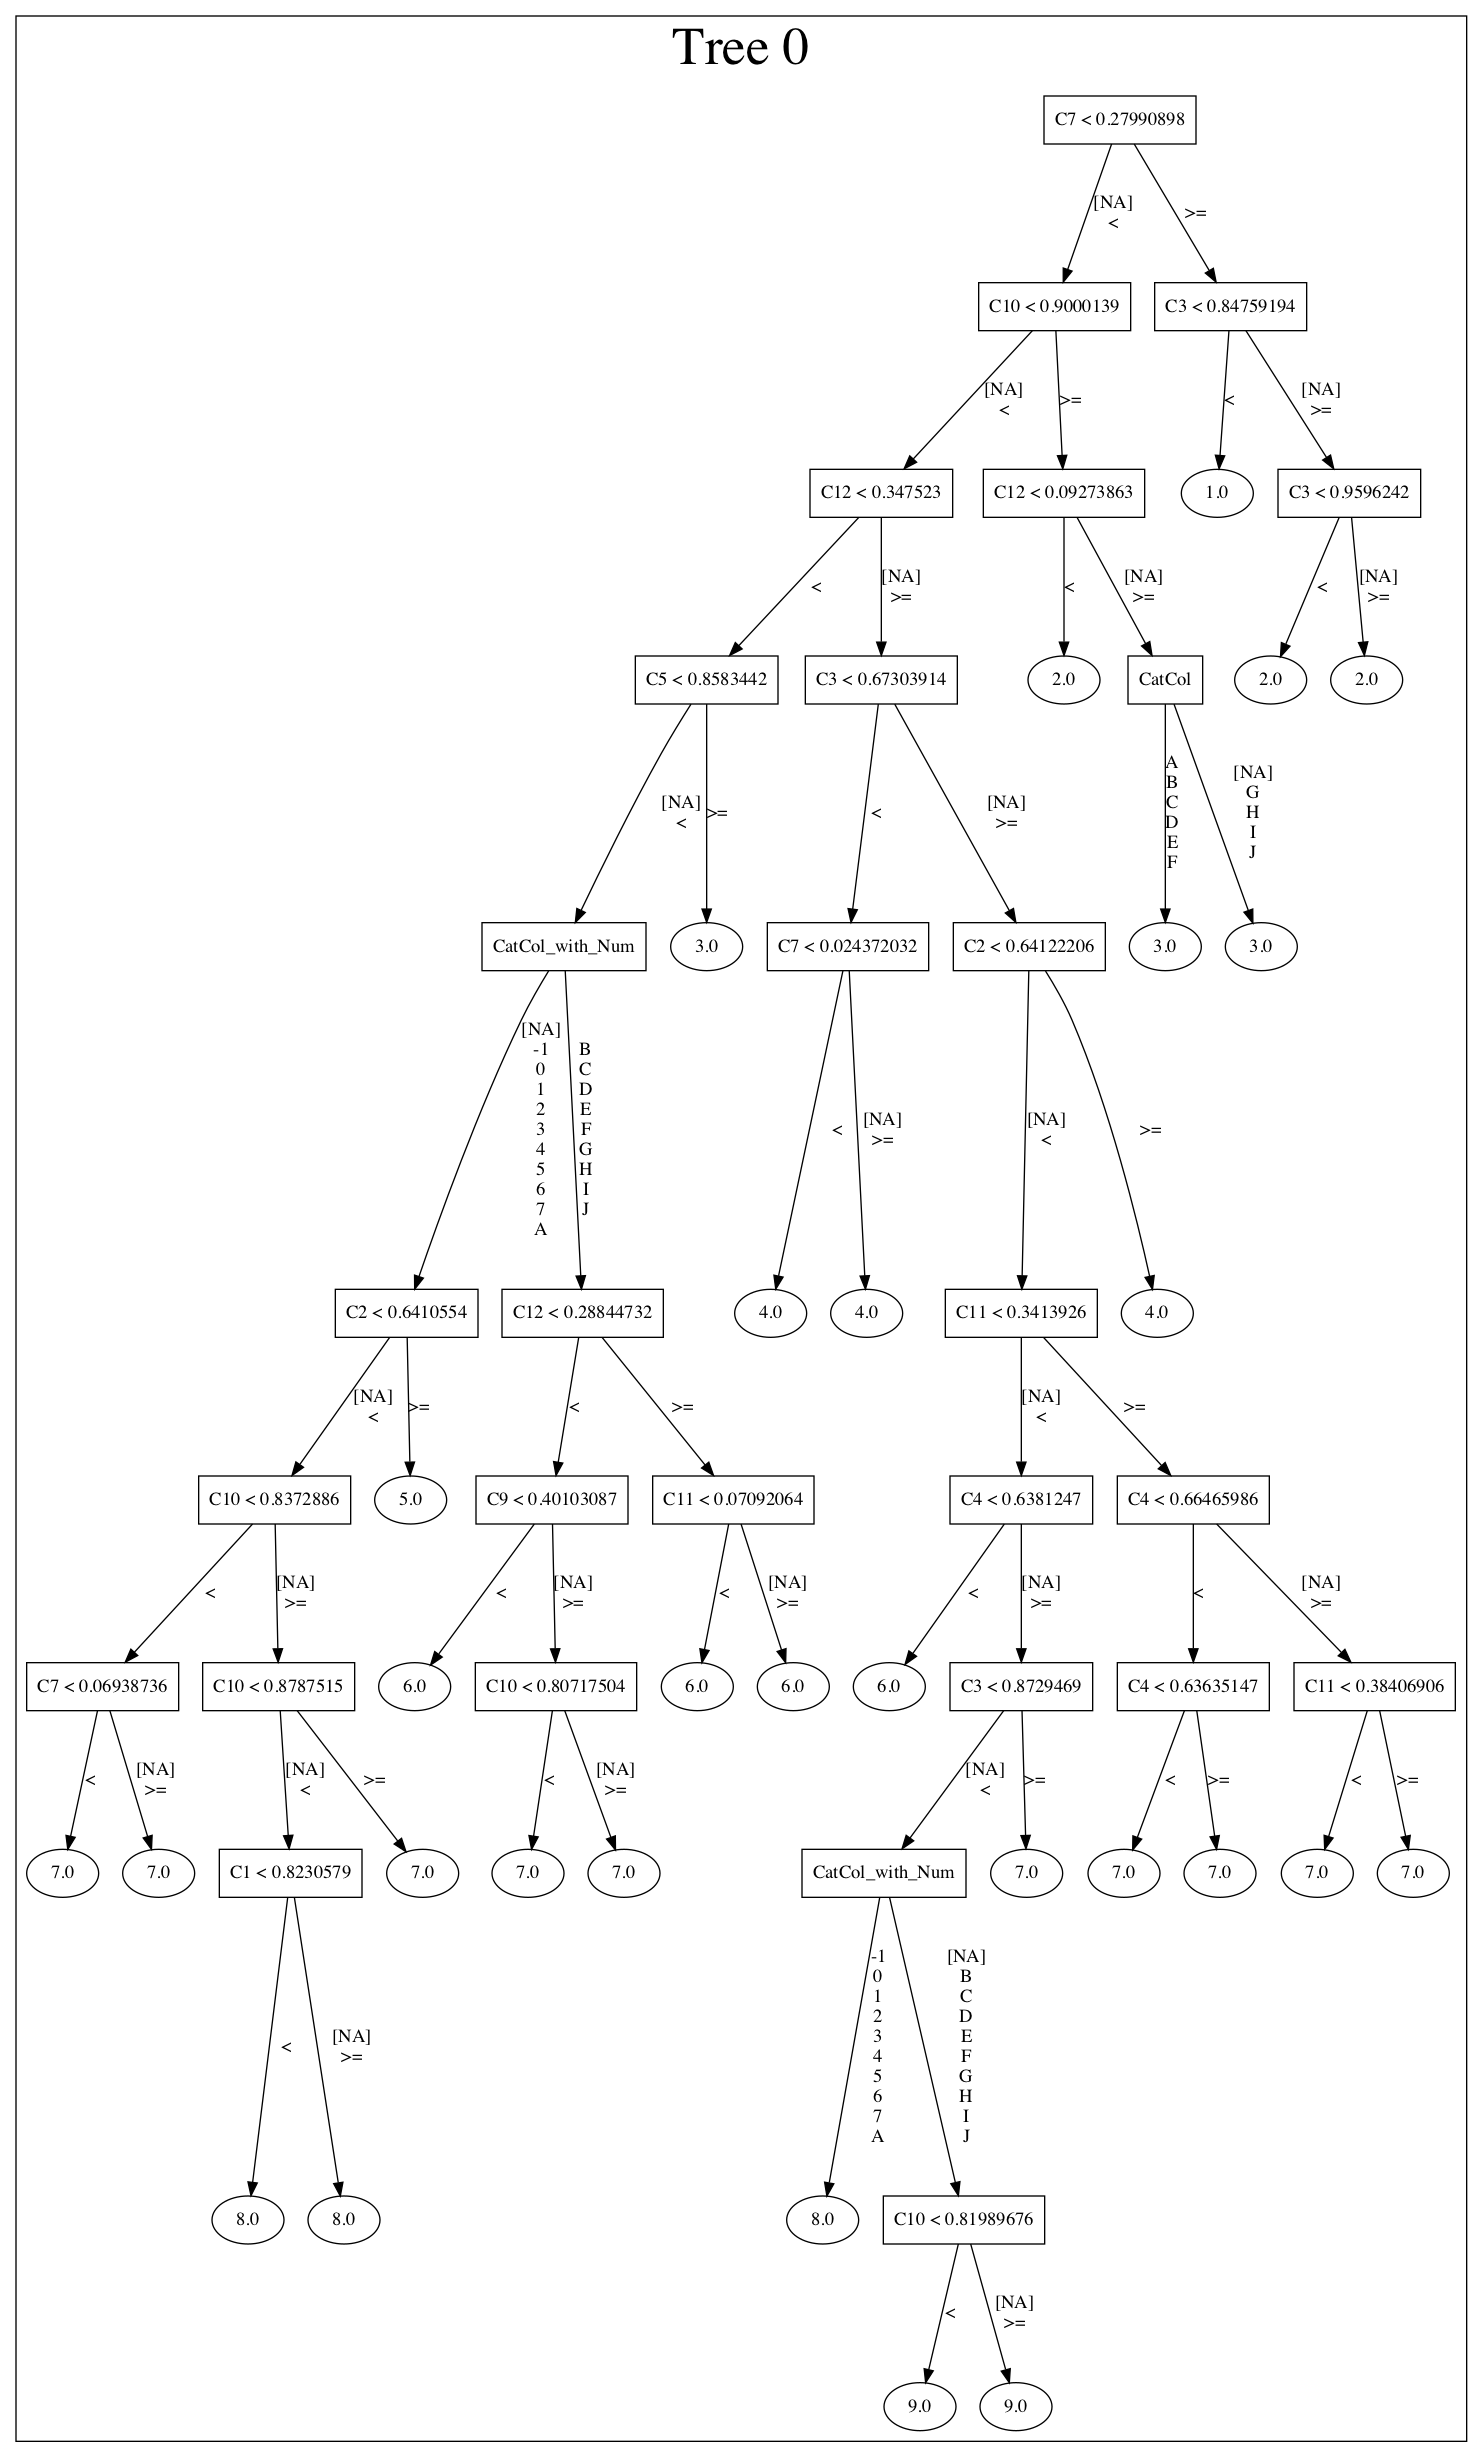

In [21]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

## Model 3 - extremely high cardinality

In [22]:
#Create new categorical column
nrows = len(train) #
l = range(nrows)
train['CatCol_Max_Cardinality'] = h2o.H2OFrame(list(l))

train['CatCol_Max_Cardinality'] = train['CatCol_Max_Cardinality'].asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [23]:
train_max = h2o.deep_copy(train, 'train_max')

train_max = train_max.drop(['CatCol', 'CatCol_with_Num'])

In [24]:
# Build an Isolation forest model
model3 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10)
model3.train(training_frame=train_max)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [25]:
model3.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


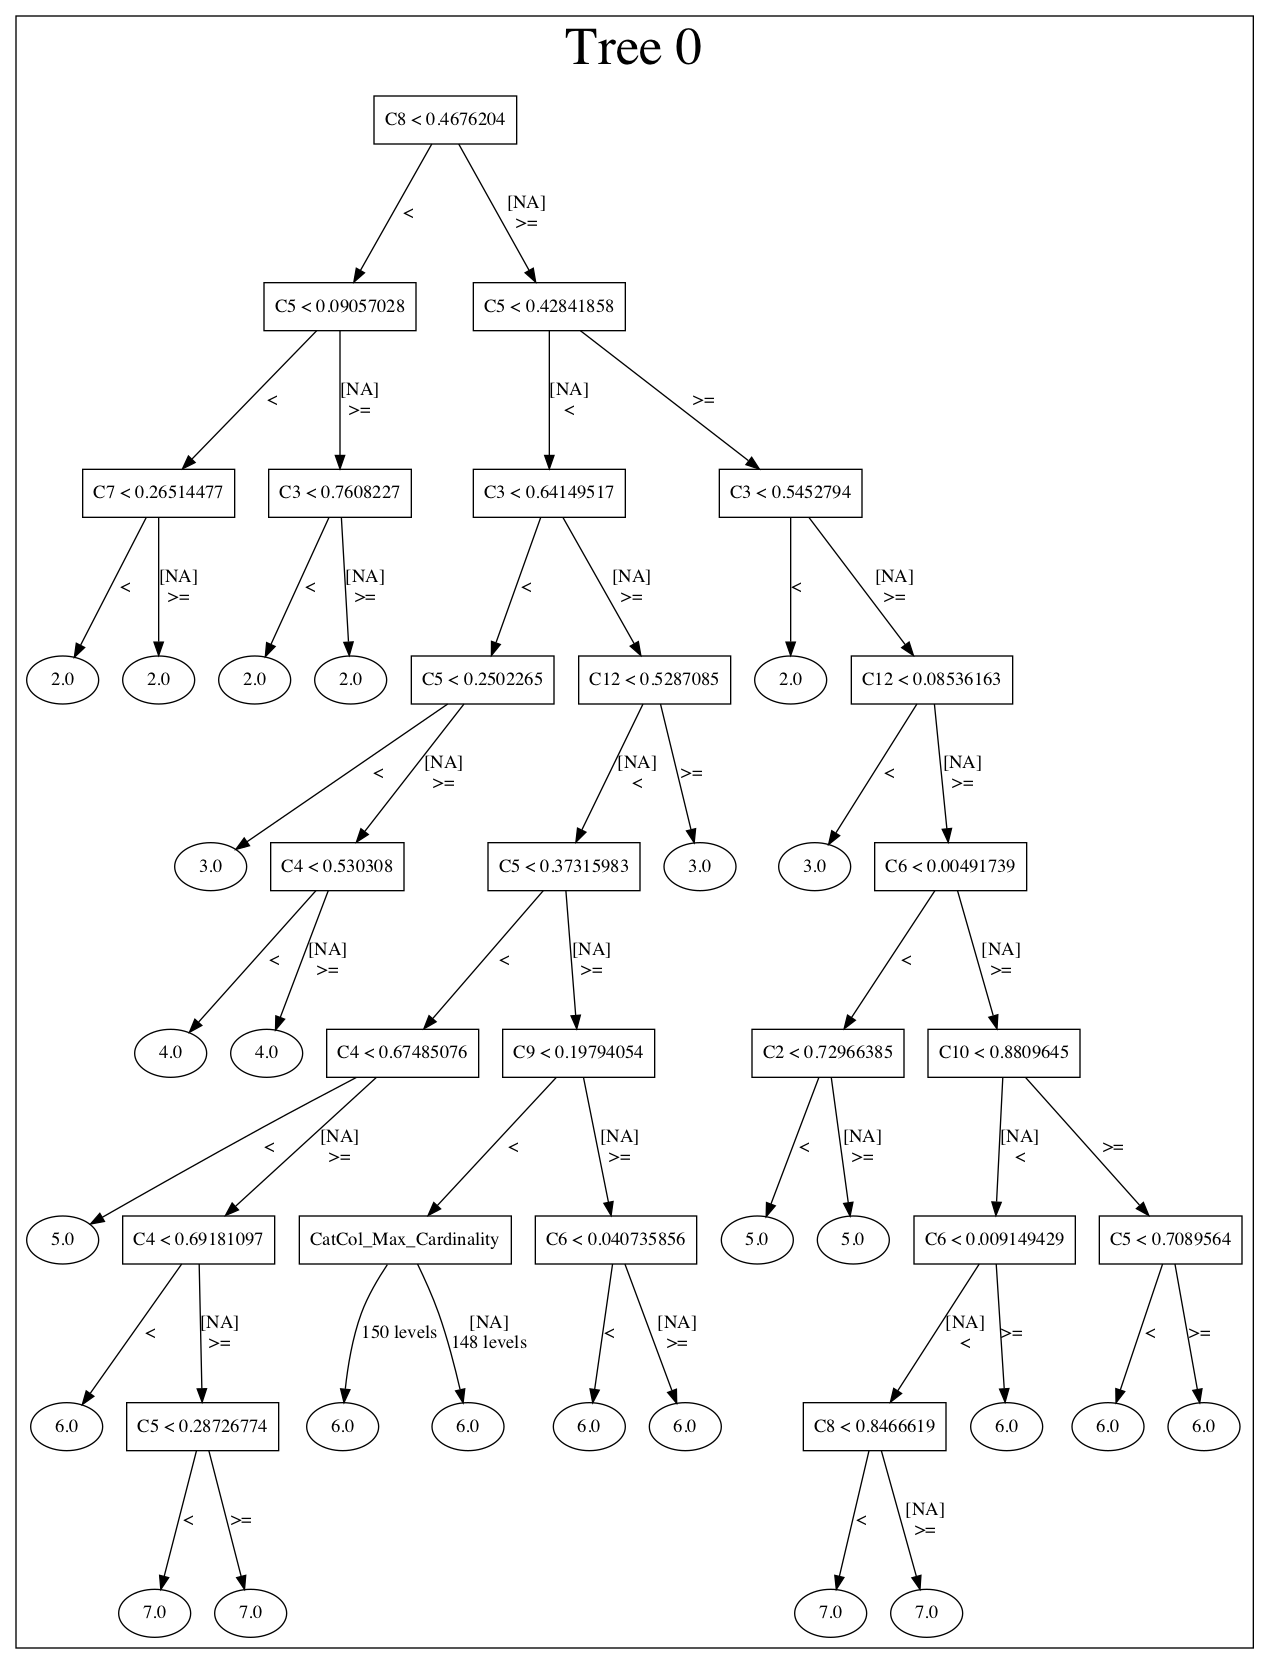

In [26]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_1.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_1.png')


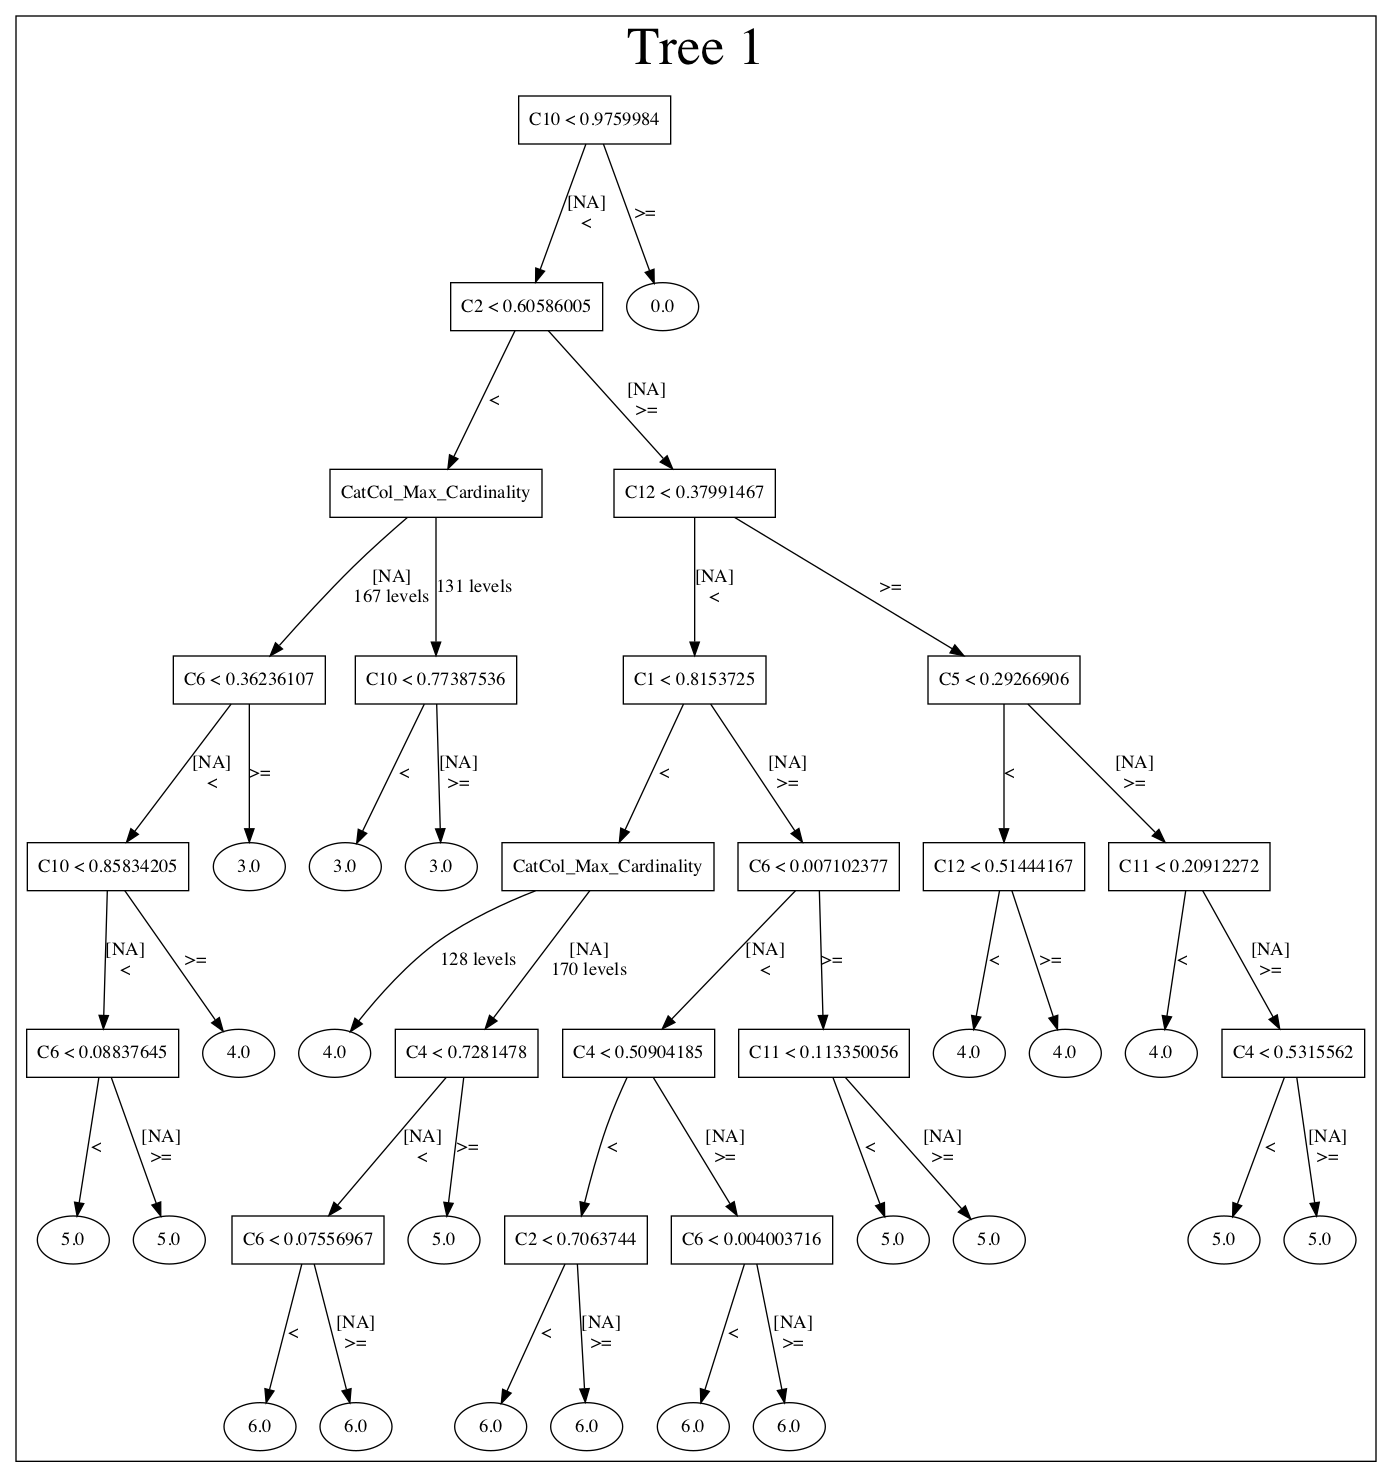

In [27]:
tree_num = 1
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

In [28]:
model3.summary()


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,10.0,10.0,4298.0,7.0,14.0,9.8,22.0,37.0,29.5


In [29]:
from h2o.tree import H2OTree

In [30]:
list_features = []

for i in range(10):
    t = H2OTree(model, i)
    list_features.extend(t.features)

s_model1 = pd.Series(list_features)

In [31]:
list_features = []

for i in range(10):
    t = H2OTree(model2, i)
    list_features.extend(t.features)

s_model2 = pd.Series(list_features)

In [32]:
list_features = []

for i in range(10):
    t = H2OTree(model3, i)
    list_features.extend(t.features)

s_model3 = pd.Series(list_features)

### Number of times feature was used in all 10 trees

In [33]:
#Model 1:
# CatCol cardinality = 10
s_model1.value_counts()

C7        26
C3        25
C12       25
C2        24
C4        24
C6        23
C11       21
C10       20
CatCol    20
C5        19
C1        19
C8        16
C9        15
dtype: int64

In [34]:
#Model 2:
# CatCol cardinality = 10
# CatCol_with_Numbers, cardinality = 19
s_model2.value_counts()

C10                29
CatCol_with_Num    29
C9                 29
C4                 25
C11                25
C5                 25
C6                 24
C12                21
C3                 21
C2                 20
C8                 18
C7                 18
CatCol             17
C1                 16
dtype: int64

In [35]:
#Model 3:
# CatCol_Max, has maximum cardinality (every row is unique) = 298
s_model3.value_counts()

C12                       28
C5                        27
C2                        27
C10                       26
C7                        25
C4                        22
C1                        22
C6                        21
C3                        19
C8                        18
C11                       18
CatCol_Max_Cardinality    17
C9                        15
dtype: int64

# Test

In [36]:
model2 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10,
                                    categorical_encoding = 'one_hot_explicit')
model2.train(training_frame=train)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [37]:
model2.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


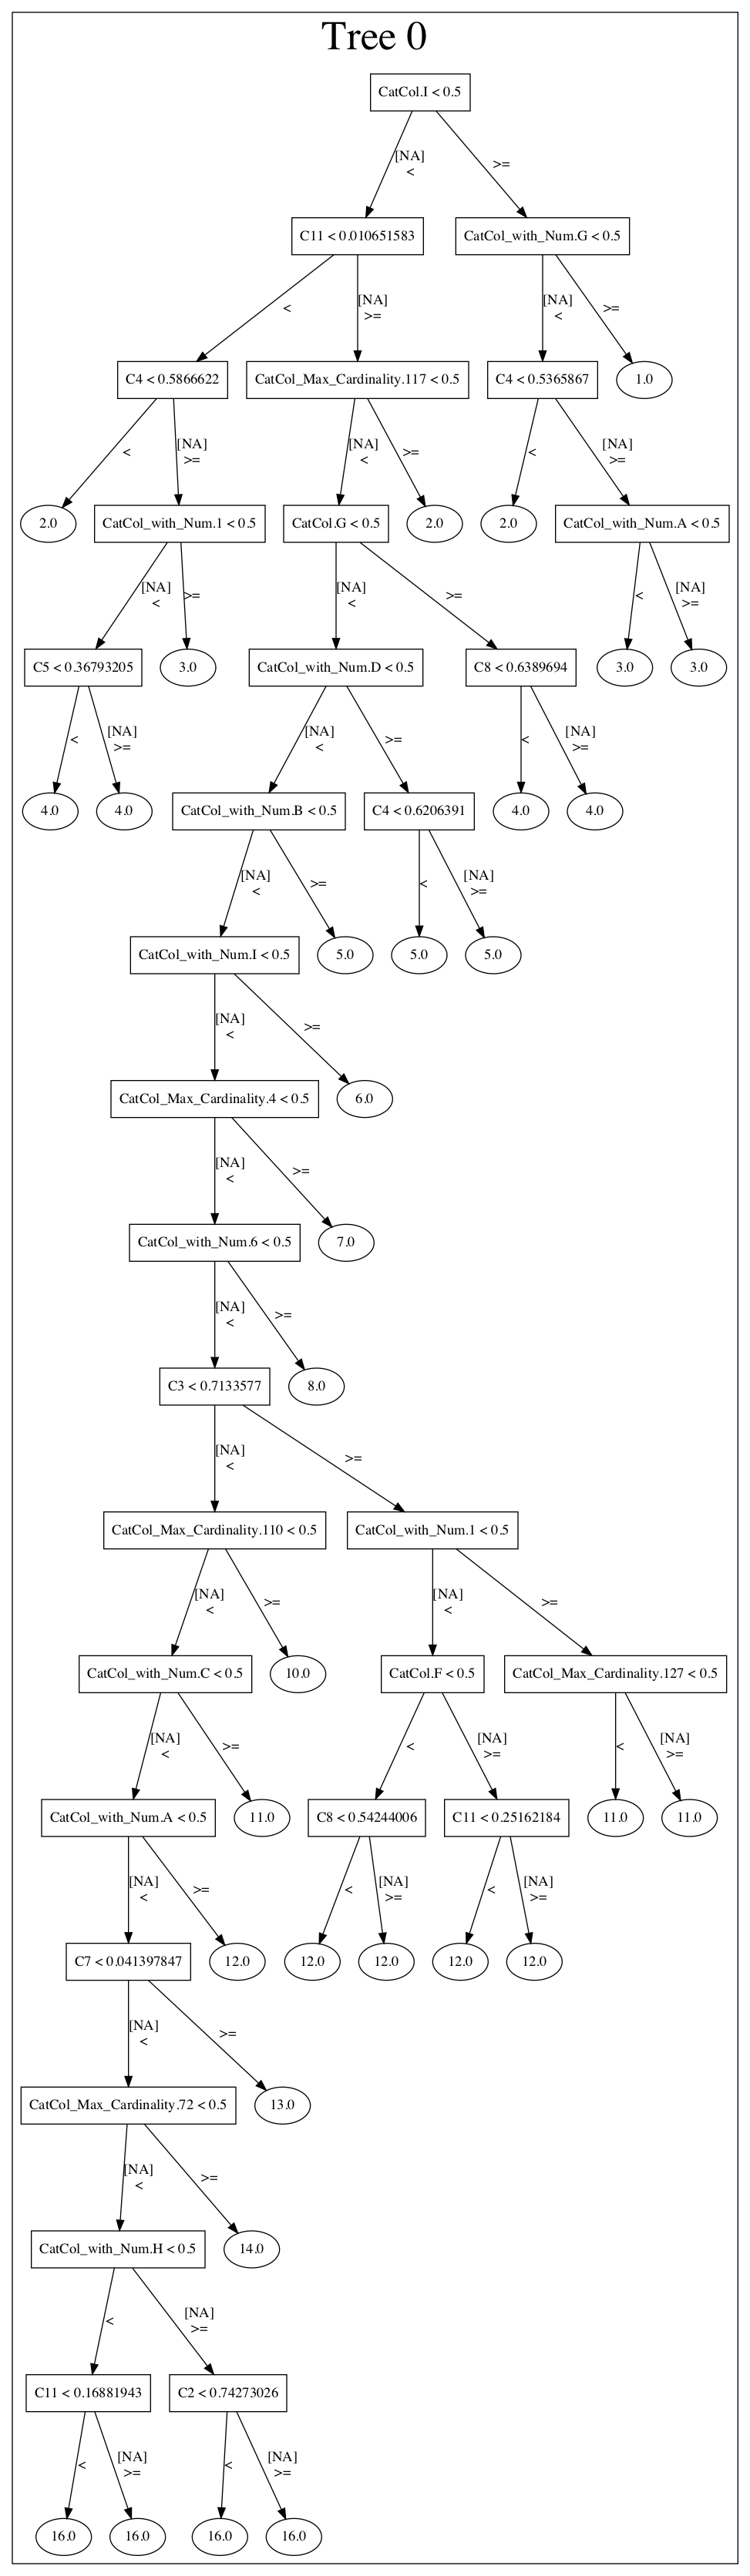

In [38]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

In [39]:
list_features = []

for i in range(10):
    t = H2OTree(model2, i)
    list_features.extend(t.features)

s_model2 = pd.Series(list_features)

In [40]:
s_model2.value_counts()

C7                            17
C3                            14
C6                            14
C11                           11
C9                            10
                              ..
CatCol_Max_Cardinality.127     1
CatCol_Max_Cardinality.193     1
CatCol_Max_Cardinality.29      1
CatCol_Max_Cardinality.86      1
CatCol_Max_Cardinality.189     1
Length: 104, dtype: int64

## Create One-Hot Encoded (for Max Cardinality) model

In [41]:
# Build an Isolation forest model
model4 = H2OIsolationForestEstimator(sample_rate = 0.1,
                                    max_depth = 20,
                                    ntrees = 10,
                                    categorical_encoding = "one_hot_explicit")
model4.train(training_frame=train_max)

/Users/nmashayekhi/anaconda3/envs/py_36_new/lib/python3.6/site-packages/h2o/estimators/estimator_base.py:200: RuntimeWarning: Stopping tolerance is ignored for _stopping_rounds=0.
  warnings.warn(mesg["message"], RuntimeWarning)


isolationforest Model Build progress: |███████████████████████████████████| 100%


In [42]:
model4.download_mojo(mojo_file_name)

'/Users/nmashayekhi/Downloads/my_gbm_mojo.zip'

Success: Graphviz file /Users/nmashayekhi/Downloads/my_gbm_graph.gv is generated.
Success: Image File /Users/nmashayekhi/Downloads/my_gbm_tree_0.png is generated.
Now you can execute the follow line as-it-is to see the tree graph:
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_0.png')


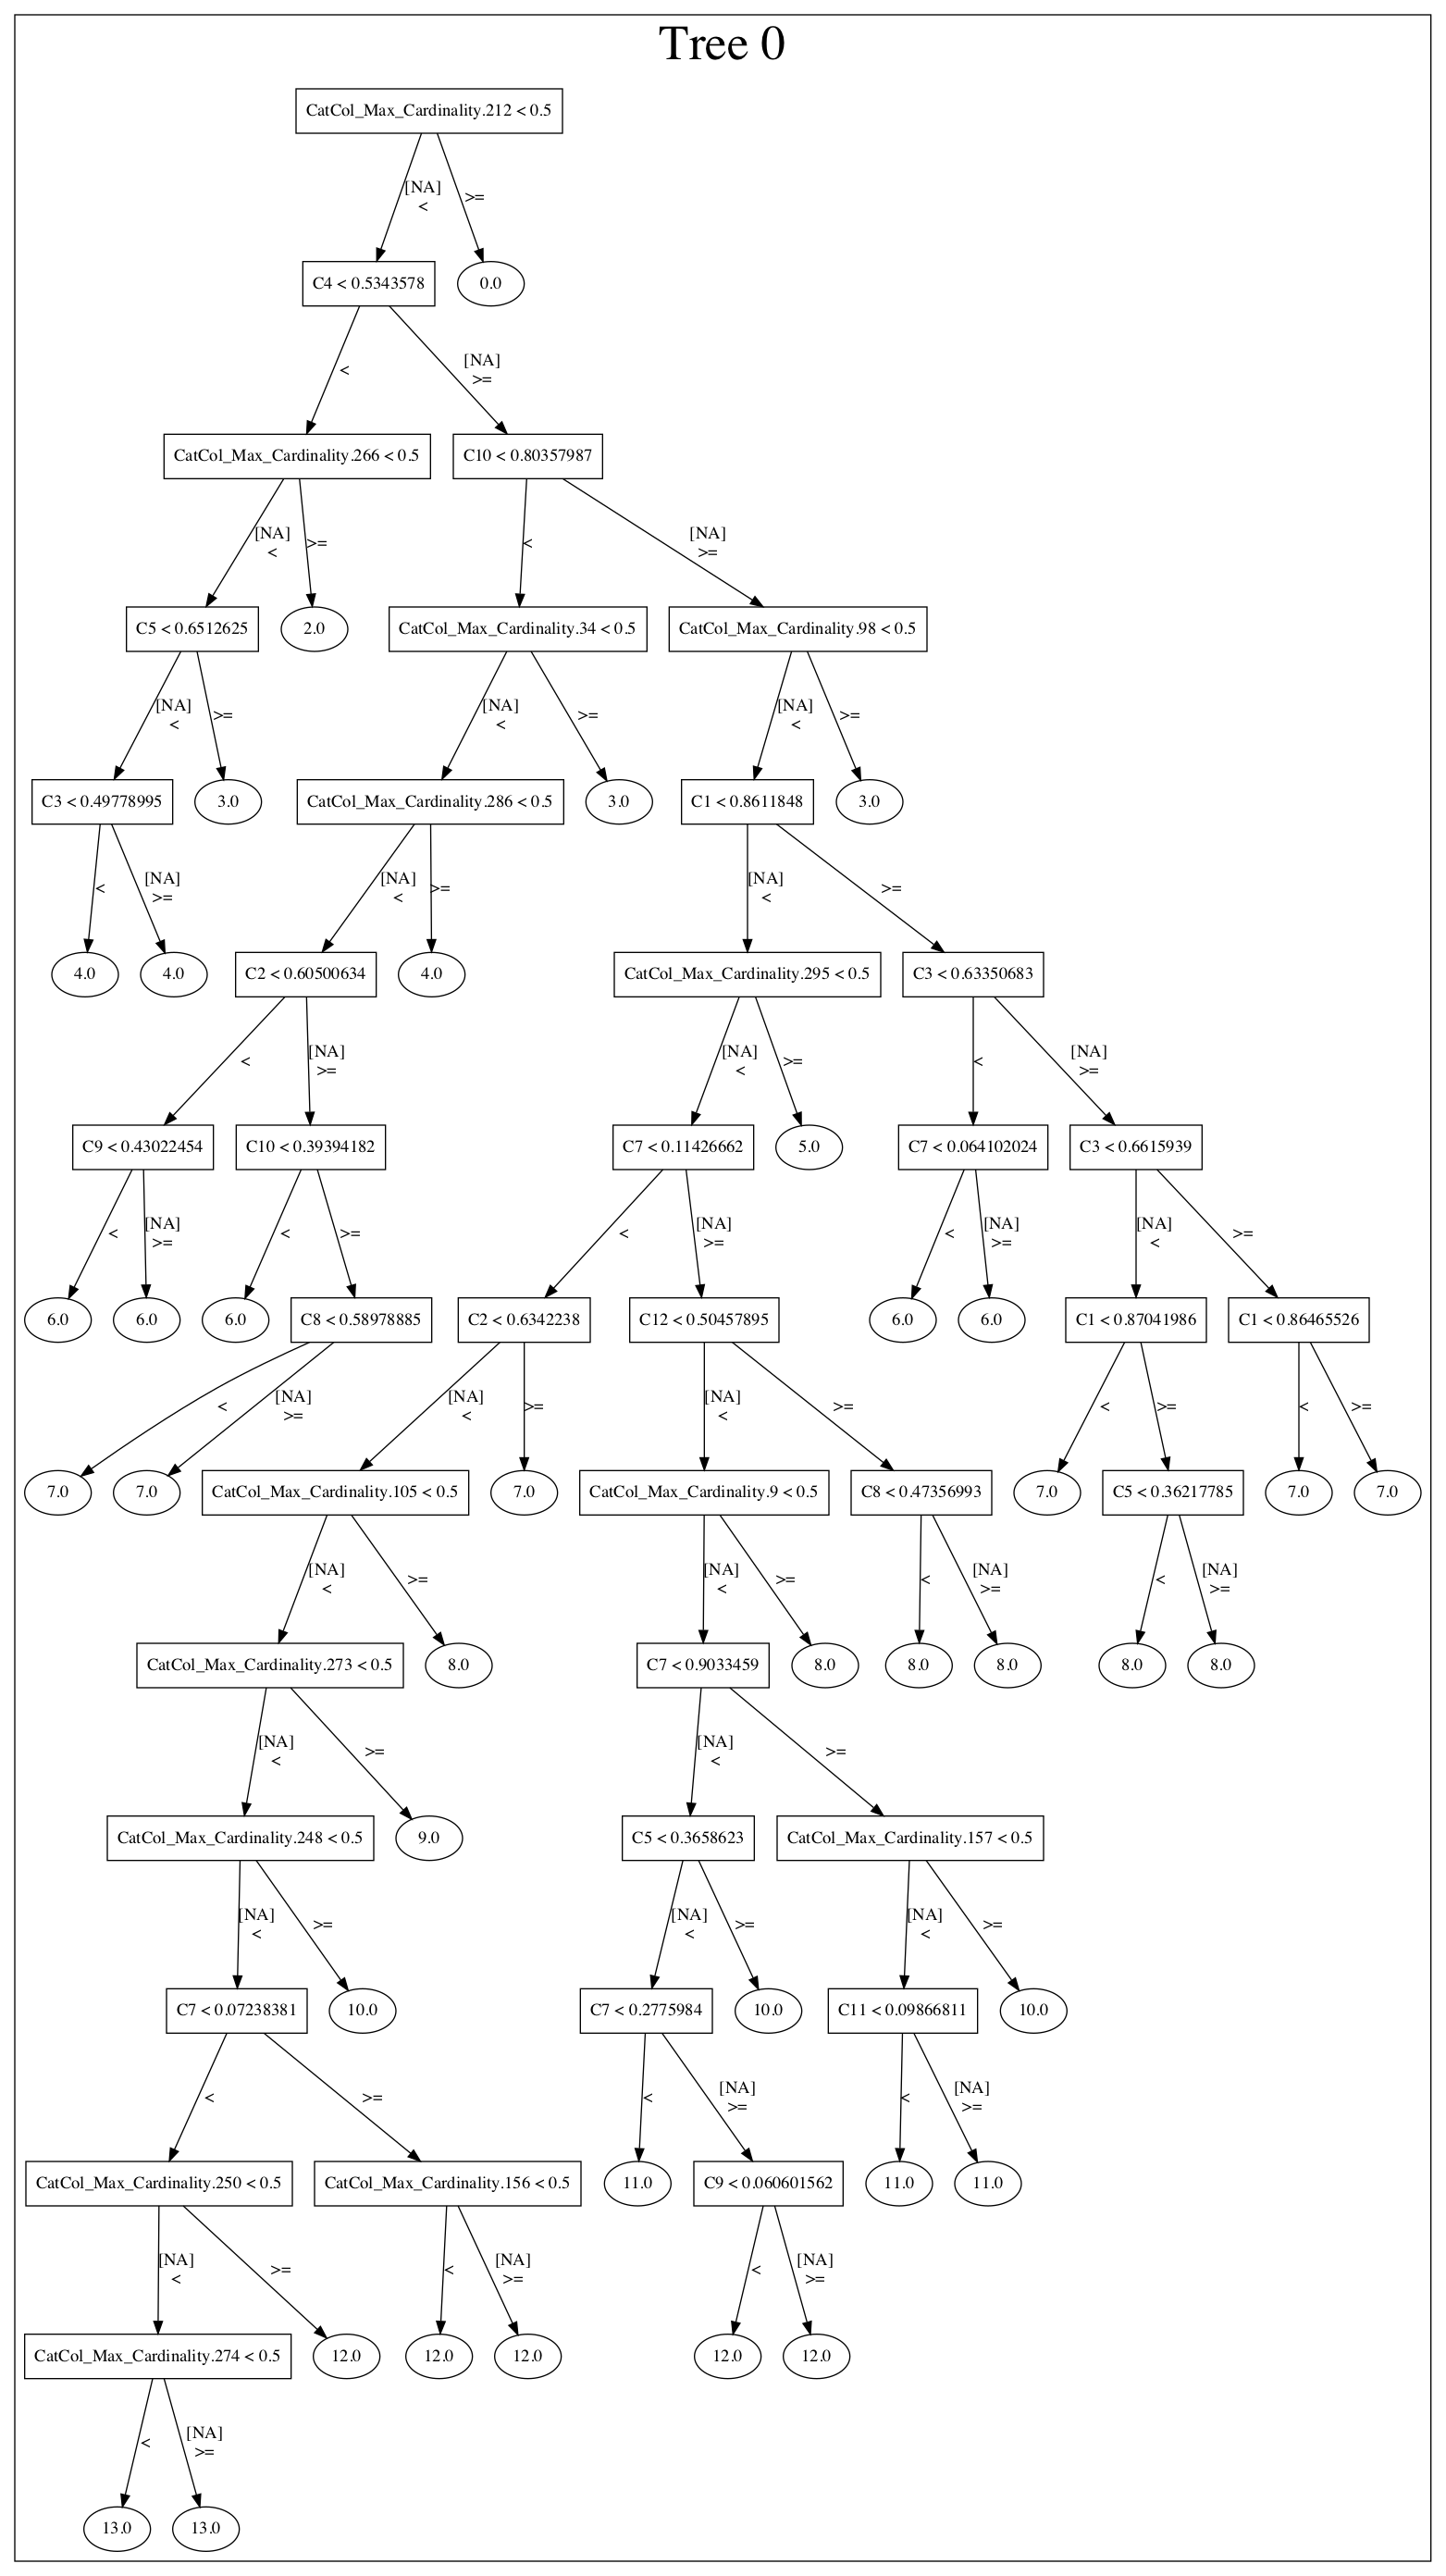

In [43]:
tree_num = 0
generateTree(h2o_jar_path, mojo_full_path, gv_file_path, image_file_name, tree_num)
generateTreeImage(gv_file_path, image_file_name, tree_num)
Image(filename='/Users/nmashayekhi/Downloads/my_gbm_tree_' + str(tree_num) + '.png')

In [44]:
list_features = []

for i in range(10):
    t = H2OTree(model4, i)
    list_features.extend(t.features)

s_model4 = pd.Series(list_features)

In [45]:
s_model4.loc[s_model4.str.contains("CatCol_Max_Cardinality.").fillna(False)] = "CatCol_Max_Cardinality"

In [46]:
#Model 4 with categorical_encoding = "one_hot_explicit"
# CatCol_Max , has maximum cardinality (every row is unique) = 298
s_model4.value_counts()

CatCol_Max_Cardinality    123
C5                         20
C1                         20
C7                         18
C11                        16
C4                         15
C10                        15
C6                         14
C8                         14
C12                        14
C9                         13
C3                         11
C2                          8
dtype: int64